<a href="https://colab.research.google.com/github/Anderson991288/ML/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

下載資料


In [ ]:
!gdown --id '1KSFIRh0-_Vr7SdiSCZP1ItV7bXPxMD92' --output data.tar.gz
!tar -zxvf data.tar.gz
!ls

Downloading...
From: https://drive.google.com/uc?id=1KSFIRh0-_Vr7SdiSCZP1ItV7bXPxMD92
To: /content/data.tar.gz
6.11MB [00:00, 54.0MB/s]
data/
data/sample_submission.csv
data/test_no_label.csv
data/train.csv
data/X_test
data/X_train
data/Y_train
data  data.tar.gz  sample_data


input Data

In [ ]:
import numpy as np

np.random.seed(0)  #隨機產生亂數
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

# 把檔案寫成Array的形式
with open(X_train_fpath) as file:
    next(file)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in file], dtype = float)
with open(Y_train_fpath) as file:
    next(file)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in file], dtype = float)
with open(X_test_fpath) as file:
    next(file)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in file], dtype = float)

# 把資料一般化
def normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # 參數:
    #     X: 要處理的資料
    #     train: 'True':處理資料, 'False':測試資料
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def _train_dev_split(X, Y, dev_ratio = 0.25):
    # This function spilts data into training set and development set.
    train_size = int(len(X) * (1 - dev_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = normalize(X_train, train = True)
X_test, _, _= normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and development set
dev_ratio = 0.1
X_train, Y_train, X_dev, Y_dev = _train_dev_split(X_train, Y_train, dev_ratio = dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]
print('Size of training set: {}'.format(train_size))
print('Size of development set: {}'.format(dev_size))
print('Size of testing set: {}'.format(test_size))
print('Dimension of data: {}'.format(data_dim))

Size of training set: 48830
Size of development set: 5426
Size of testing set: 27622
Dimension of data: 510


**Logistic Regression**:是一個平滑的曲線，當w0*x0+w1*x1+…+wn*xn越大時判斷成A類的
機率越大，越小時判斷成A類的機率越小。


由於是二元分類，如果判斷成A類的機率越小，B類的機率越大(判斷成B類的機率 = 1 - 判斷成A的機率)。

In [ ]:
def shuffle(X, Y):
    # 打亂數據的順序
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

def sigmoid(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-8, 1 - (1e-8))  # numpy.clip( a , a_min , a_max)

def f(X, w, b):
    # logistic regression function
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return sigmoid(np.matmul(X , w) + b)  #np.matmul(X, w):矩陣相乘

def predict(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(f(X, w, b)).astype(np.int)  #np.round: 四捨五入
    
def accuracy(Y_pred, Y_label):
    # 計算預測的準確度
    accuracy = 1 - np.mean(np.abs(Y_pred - Y_label))
    return accuracy

**cross_entropy:**    Loss函数的一種（也稱為損失函數），用來描述模型預測值與真實值的差距大小 

In [ ]:
def cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label , np.log(y_pred)) - np.dot((1 - Y_label) , np.log(1 - y_pred))
    return cross_entropy

def gradient(X, Y_label, w, b):
    # This function computes the gradient of cross entropy loss with respect to weight w and bias b.
    y_pred = f(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad


**Mini-batch training:**把訓練集分割成比較小的， 一堆小小的資料集，我們稱他們稱為 "mini-batches" 


用小批次梯度下降把整個訓練集處理過一次，也稱為「做一個 “epoch” 的訓練」。 “epoch” 的意思是把訓練集掃過一遍。

參考:
https://medium.com/%E5%AD%B8%E4%BB%A5%E5%BB%A3%E6%89%8D/%E5%84%AA%E5%8C%96%E6%BC%94%E7%AE%97-5a4213d08943

In [ ]:
# Zero initialization for weights ans bias
# 初始化
w = np.zeros((data_dim,)) 
b = np.zeros((1,))

# 一些訓練會用到的參數   
max_iter = 10
batch_size = 8
learning_rate = 0.2

# Keep the loss and accuracy at every iteration for plotting
# 儲存損失跟準度(繪圖用)
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# Calcuate the number of parameter updates
step = 1

# Iterative training(迭代訓練)
for epoch in range(max_iter):
    # Random shuffle at the beginning of each epoch
    X_train, Y_train = shuffle(X_train, Y_train)
        
    # Mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):   #np.floor : 向下取整
        X = X_train[idx * batch_size : (idx+1) * batch_size]
        Y = Y_train[idx * batch_size : (idx+1) * batch_size]

        # 計算梯度
        w_grad, b_grad = gradient(X, Y, w, b)
            
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad

        step = step + 1
            
    # Compute loss and accuracy of training set and development set
    y_train_pred = f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(accuracy(Y_train_pred, Y_train))
    train_loss.append(cross_entropy_loss(y_train_pred, Y_train) / train_size)

    y_dev_pred = f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(accuracy(Y_dev_pred, Y_dev))
    dev_loss.append(cross_entropy_loss(y_dev_pred, Y_dev) / dev_size)

print('Training loss: {}'.format(train_loss[-1]))
print('Development loss: {}'.format(dev_loss[-1]))
print('Training accuracy: {}'.format(train_acc[-1]))
print('Development accuracy: {}'.format(dev_acc[-1]))

Training loss: 0.27135543524640593
Development loss: 0.2896359675026287
Training accuracy: 0.8836166291214418
Development accuracy: 0.8733873940287504


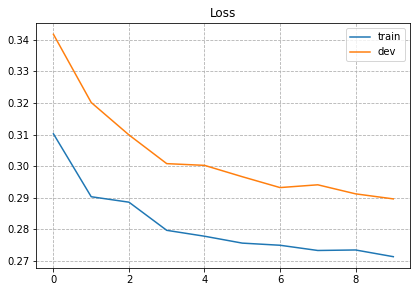

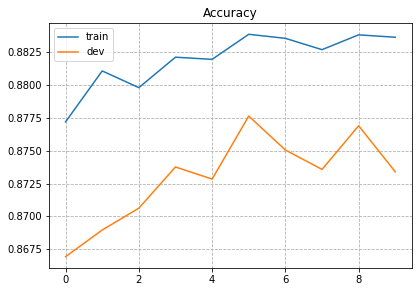

In [ ]:
import matplotlib.pyplot as plt

# Loss curve
fig = plt.gcf()
fig.set_size_inches(6.7, 4.5)
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train', 'dev'])
plt.grid(ls='--')
plt.savefig('loss.png')
plt.show()

# Accuracy curve
fig = plt.gcf()
fig.set_size_inches(6.5, 4.5)
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train', 'dev'])
plt.grid(ls='--')
plt.savefig('acc.png')
plt.show()

In [ ]:
# Predict testing labels
predictions = predict(X_test, w, b)
with open(output_fpath.format('logistic'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Not in universe -4.031960278019251
 Spouse of householder -1.625403958705141
 Other Rel <18 never married RP of subfamily -1.4195759775765404
 Child 18+ ever marr Not in a subfamily -1.2958572076664745
 Unemployed full-time 1.1712558285885912
 Other Rel <18 ever marr RP of subfamily -1.167791807296237
 Italy -1.093458143800618
 Vietnam -1.0630365633146415
num persons worked for employer 0.938992277356651
 1 0.8226614922117185


In [ ]:
# Parse csv files to numpy array
# 把檔案寫成Array的形式
with open(X_train_fpath) as file:
    next(file)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in file], dtype = float)
with open(Y_train_fpath) as file:
    next(file)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in file], dtype = float)
with open(X_test_fpath) as file:
    next(file)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in file], dtype = float)

# Normalize training and testing data
# 把資料一般化
X_train, X_mean, X_std = normalize(X_train, train = True)
X_test, _, _= normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

In [ ]:
# Compute in-class mean
X_train_0 = np.array([x for x, y in zip(X_train, Y_train) if y == 0])
X_train_1 = np.array([x for x, y in zip(X_train, Y_train) if y == 1])

mean_0 = np.mean(X_train_0, axis = 0)
mean_1 = np.mean(X_train_1, axis = 0)  

# Compute in-class covariance       #covariance : 共變異數 (算x和y的相關程度)
cov_0 = np.zeros((data_dim, data_dim))
cov_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]), [x - mean_0]) / X_train_0.shape[0]
for x in X_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]), [x - mean_1]) / X_train_1.shape[0]

# Shared covariance is taken as a weighted average of individual in-class covariance.
cov = (cov_0 * X_train_0.shape[0] + cov_1 * X_train_1.shape[0]) / (X_train_0.shape[0] + X_train_1.shape[0])

In [ ]:
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# Directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
b =  (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(X_train_0.shape[0]) / X_train_1.shape[0]) 

# Compute accuracy on training set
Y_train_pred = 1 - predict(X_train, w, b)
print('Training accuracy: {}'.format(accuracy(Y_train_pred, Y_train)))

TypeError: ignored

In [ ]:
# Predict testing labels
predictions = 1 - predict(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id,label\n')
    for i, label in  enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# Print out the most significant weights
# argsort()函式是將x中的元素從小到大排列，提取其對應的index(索引)，然後輸出到y  (把index排序)
ind = np.argsort(np.abs(w))[::-1]       # [::-1] 把順序顛倒
with open(X_test_fpath) as file:
    content = file.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])